# Import dependencies

In [1]:
import os
import pandas as pd
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.loader import DataLoader
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

from utils.data.load_root import load_root
from utils.data.build_graph import build_graphs
from utils.data.load_graphs import load_graphs
from utils.evaluation.evaluate_graphs import evaluate_data, evaluate_graphs
from utils.plotting.plot_events import plot_information, plot_event
from utils.data.graphdata import GraphDataset
from utils.models.interaction_network import InteractionNetwork
from utils.training.train_3 import train_model
from utils.evaluation.evaluate_model import evaluate_model


# Import Root data

In [2]:
%%time
load_rootdata = False

if load_rootdata:
    path = "~/Documents/Masterarbeit/Panda_Software/PandaRoot/dev/source/macro/data/evtcomplete"
    raw = load_root(path, showentries=True)
    raw.to_hdf('data/raw.h5', key='df', mode='w')  

else:
    raw = pd.read_hdf('data/raw.h5', 'df')  

CPU times: user 113 ms, sys: 109 ms, total: 221 ms
Wall time: 220 ms


Choose number of events to be analysed

In [45]:
nevents = raw.index.max()
nevents = 30000
node_dim = 2
edge_dim = 2

# Investigate raw data

In [46]:
%%time

show=False
if show:
   
    plot_information(raw).plot_ntracks_nhits()
    evID=np.random.randint(nevents)
    evID = 3
    event = raw.loc[raw.index==evID]
    plot_event(event, scale=1.8).plot_eventdisplay()
    
    data_eval = evaluate_data(raw, ncuts=50)
    data_eval.curler_dist()

    purity, efficiency, cuts, cutPos, TNR, FNR = data_eval.find_pzcut()
    data = plot_information()
    data.plot_purity_efficiency(cuts, 25, purity, efficiency, TNR, FNR, nevents, variable = r'$p_z^{min}$', xname = r'$p_z^{min}$ (GeV/c)', yname = 'purity & efficiency', save_name = 'img/3_pz_threshold.pdf')


CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 7.87 µs


# Graph building for training

In [47]:
in_dir = 'data/graphs'
# pz_min = 0.001
# slope_max = 0.582
pz_min = 0.003
slope_max = 0.6

graph_dir = f'{in_dir}_pzmin_{pz_min}_slopemax_{slope_max}'

In [48]:
%%time

data = build_graphs(raw,end=30000, shuffle=True,  pz_min=pz_min, remove_duplicates=True, slope=slope_max)
create_g = False

if create_g:
    os.makedirs(graph_dir, exist_ok=True)  
    graphs = data.create_graph_list(node_dim=node_dim, edge_dim=edge_dim, minlayer=0, maxlayer=24)
    targets = []

    data_paths = [i for i in (os.path.join(graph_dir, f) for f in os.listdir(graph_dir)) if os.path.isfile(i)]
    for f in data_paths:
        os.remove(f)

    for graph in graphs:
        evID = graph.pid.index.unique()[0]
        x, edge_attr, edge_index, y, pid = graph
        targets.append(y)
        arr = np.asanyarray([x, edge_attr, edge_index, y, pid], dtype=object)
              
        np.save(os.path.join(graph_dir, f'graph_{evID}.npy'), arr)
    print(f'graphs saved to {graph_dir}')

    targets = np.concatenate(targets)
    print(f'signal fraction true/all edges: {np.sum(targets)/len(targets)}')

else:
    graphs = load_graphs(graph_dir, n_graphs='all', node_dim=2, edge_dim=2) #load n random sample graphs

#show preprocessed data
data.events.sort_index()

CPU times: user 9.9 s, sys: 634 ms, total: 10.5 s
Wall time: 10.5 s


,hit_id,particle_id,x,z,iso,pz,chamber_id,skewed,layer_id,layer,Hit_id
event_id,,,,,,,,,,,
0,864242,3,-10.857500,326.894989,0.110826,7.725154,2,0,9,5,77
0,271738,2,65.397499,607.869690,0.456482,7.616089,5,0,34,18,133
0,2452790,0,26.512501,422.964996,0.381700,2.424508,3,0,23,11,219
0,3085627,3,-9.342500,295.769684,0.413430,7.725302,1,0,2,2,70
0,2497886,4,15.907500,438.364685,0.305180,5.259765,4,0,26,14,47
...,...,...,...,...,...,...,...,...,...,...,...
29999,2006822,3,-2.272500,654.364685,0.391143,5.490438,6,0,48,24,143
29999,1765218,4,-23.482500,394.869690,0.279434,6.251751,3,0,18,10,66
29999,423104,3,4.797500,342.264679,0.373299,5.498895,2,0,16,8,112


# Evaluate Graph building
for comparison with original raw data choose evaluate_graphs(data.raw.rename(columns={'layer_id':'layer'}), graphs).evaluate_graphs()

In [7]:
%%time
evaluate_gb = False
test_samples = 1000
ncuts = 100

if evaluate_gb:
        
    testdata = build_graphs(raw,end=test_samples, shuffle=True, pz_min=pz_min, remove_duplicates=True, slope=slope_max)
    slope = np.linspace(0.1,1,ncuts)
    purities, efficiencies, TNRs, FNRs = np.zeros((4,ncuts))
    nnodes, nedges = [], []
           
    for i, s in enumerate(tqdm(slope)):
        testdata.slope = s
        testgraphs = testdata.create_graph_list(show_progress=False, node_dim=2, edge_dim=2)
        purity, efficiency, TNR, FNR, _ = evaluate_graphs(testdata.events, testgraphs).evaluate_graphs(show_progress=False)
        purities[i] = purity
        efficiencies[i] = efficiency
        TNRs[i] = TNR
        FNRs[i] = FNR
        
        ne = []
        
        for g in testgraphs:
            ne.append(len(g.y))
        nedges.append([np.mean(ne), np.std(ne)])
    nn = []
    for g in testgraphs:
        nn.append(len(g.x))
    nnodes = [np.mean(nn), np.std(nn)]
    print(f'average number of nodes: {nnodes[0]:.2f} with standard deviation {nnodes[1]:.2f}')
    nedges = np.array(nedges)
        
                
    show_infos = plot_information(graphs=graphs[:test_samples], pz_min=pz_min, slope_max=slope_max)
    cutPos = np.argmin(np.abs(np.array(purities)-np.array(efficiencies)))
    print(cutPos)
    cutPos = 53
    show_infos.plot_purity_efficiency(slope, cutPos, purities, efficiencies, TNRs, FNRs, test_samples, r'$s^{max}$', r'$s^{max}$', 'purity & efficiency', 'img/3_graphbuilding_purity_efficiency.pdf', add_inf=r',  $p_z^{min} =$ '+f'{pz_min:.3f}')
    show_infos.plot_graph_data_info()
    
    show_infos.plot_graph_dimensions(nnodes, nedges, slope, test_samples)

CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.25 µs


# Plot Graphs

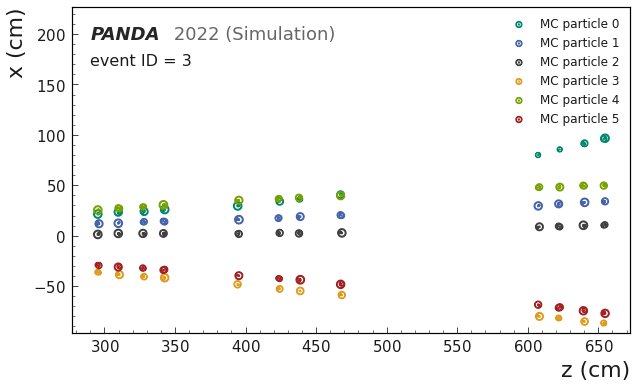

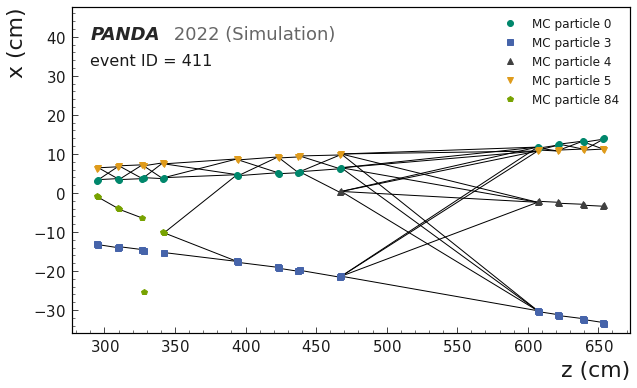

CPU times: user 1.8 s, sys: 1.19 s, total: 2.99 s
Wall time: 1.46 s


In [8]:
%%time
evID = np.random.randint(nevents)
evID = 3

hits = data.events.loc[evID]
graph = graphs[evID]

plotevent = plot_event(hits, graph=graph, shift=.14, scale=1.6)
plotevent.plot_eventdisplay()
plotevent.plot_graphdisplay()


# Prepare Training

In [49]:
# torch.manual_seed(42)
device = 'cpu'
hidden_size = 8
name = f'IN_trained_{nevents}_neurons_{hidden_size}'
lr = 0.01
gamma = 0.7
epochs = 50
patience = 5
step_size = 3





In [50]:
batch_size = 8
parts = [0.8, 0.1, 0.1] #sizes of training, validation and testing samples
load_params = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 16}

parts = np.cumsum((nevents*np.array(parts)).astype(int))
partition = {'train': graphs[:parts[0]],  
             'test':  graphs[parts[0]:parts[1]],
             'val': graphs[parts[1]:parts[2]]}


train_set = GraphDataset(partition['train'])
train_loader = DataLoader(train_set, **load_params)
test_set = GraphDataset(partition['test'])
test_loader = DataLoader(test_set, **load_params)
val_set = GraphDataset(partition['val'])
val_loader = DataLoader(val_set, **load_params)

In [51]:
model = InteractionNetwork(node_dim, edge_dim, hidden_size).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = StepLR(optimizer, step_size=step_size, gamma=gamma)

model.count_parameters()

InteractionNetwork(node_dim: 2, edge_dim: 2, hidden_size: 8)
+--------------------+------------+
|      Modules       | Parameters |
+--------------------+------------+
| R1.layers.0.weight |     48     |
|  R1.layers.0.bias  |     8      |
| R1.layers.2.weight |     64     |
|  R1.layers.2.bias  |     8      |
| R1.layers.4.weight |     16     |
|  R1.layers.4.bias  |     2      |
| O.layers.0.weight  |     32     |
|  O.layers.0.bias   |     8      |
| O.layers.2.weight  |     64     |
|  O.layers.2.bias   |     8      |
| O.layers.4.weight  |     16     |
|  O.layers.4.bias   |     2      |
| R2.layers.0.weight |     48     |
|  R2.layers.0.bias  |     8      |
| R2.layers.2.weight |     64     |
|  R2.layers.2.bias  |     8      |
| R2.layers.4.weight |     8      |
|  R2.layers.4.bias  |     1      |
+--------------------+------------+
Total Trainable Params: 413


# Training

In [ ]:
from utils.training.train_3 import train_model

torch.manual_seed(42)
device = 'cpu'
hidden_size = 8
name = f'IN_trained_{nevents}_neurons_{hidden_size}'
lr = 0.02
gamma = 0.7
epochs = 20
patience = 5
step_size = 3

results = train_model(
    train_loader, 
    val_loader, 
    model, 
    optimizer, 
    scheduler, 
    device=device,
    epochs=epochs, 
    patience=patience, 
    name='trained_IN'
)

  0%|                                                    | 0/20 [00:00<?, ?it/s]

# Evaluate Training

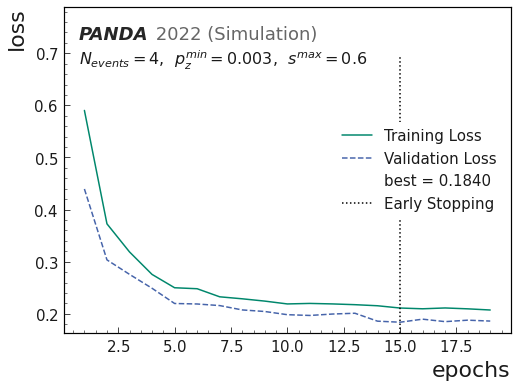

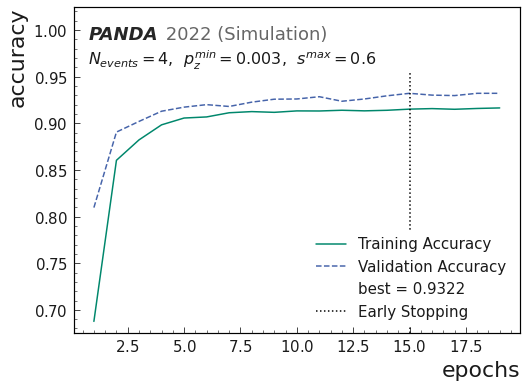

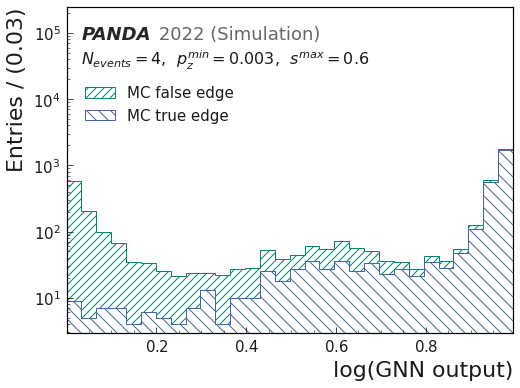

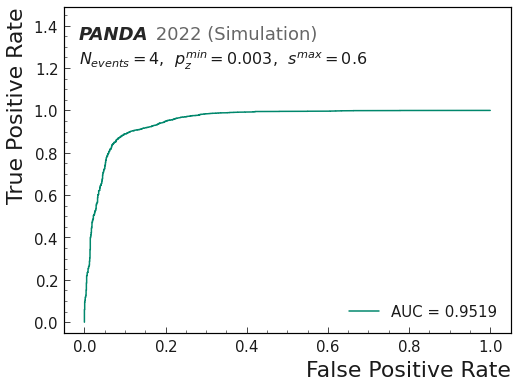

100%|██████████████████████████████████████| 100/100 [00:00<00:00, 36002.61it/s]


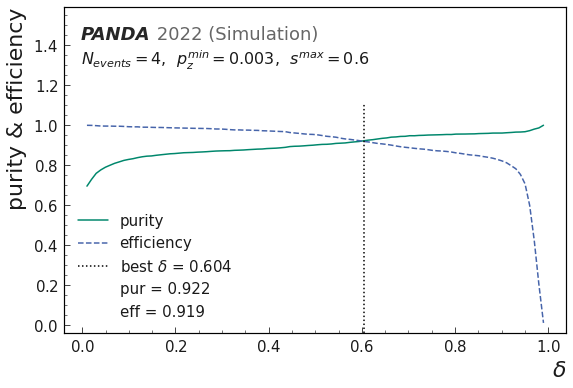

best $\delta$ threshold at 0.6039, removed bad (TNR): 0.846, lost good (FNR): 0.081


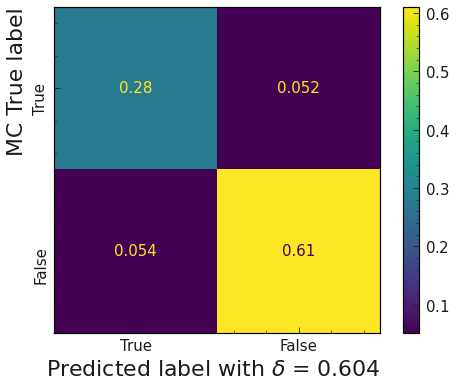

In [44]:
model, train_output = results.trained

threshold = 0.7
evaluation = evaluate_model(model, test_loader, pz_min, slope_max, train_output, threshold, ncuts=100)
evaluation.plot_loss()
evaluation.plot_acc()
evaluation.plot_metrics()

# Show Results

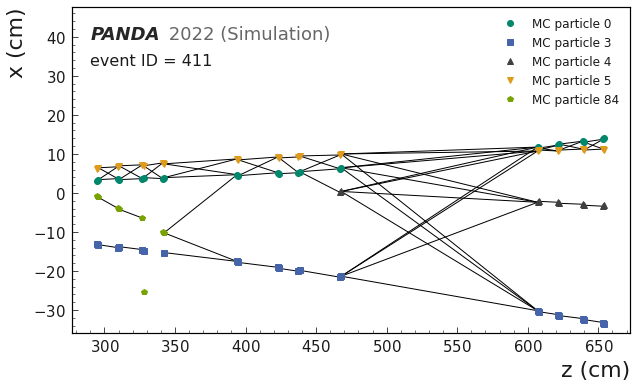

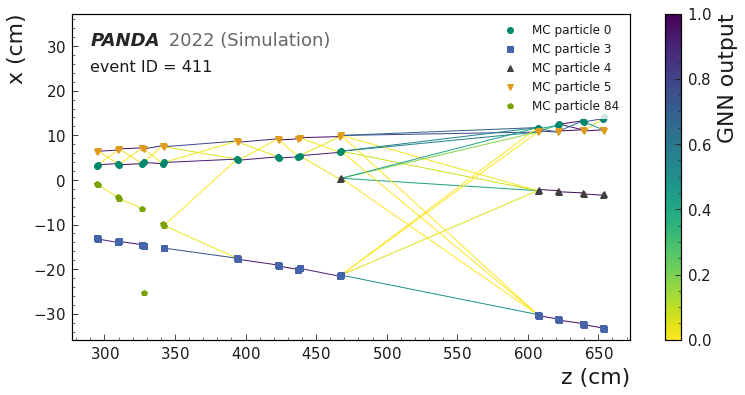

In [15]:
plot_event(hits, graph, scale=1.6).plot_graphdisplay()
plot_event(hits, graph).plot_traineddisplay(model)

In [16]:
data = GraphDataset(graphs[:1000])

In [17]:
import matplotlib.pyplot as plt
import torch.nn.functional as F

outputs, targets, zs = [], [], []

for d in tqdm(data):
    output = model(d).squeeze(1).detach().numpy()
    y = d.y.detach().numpy()
    
    outputs = np.append(outputs, output)
    targets = np.append(targets, y) 
    zs = np.append(zs, np.abs(d.edge_attr[:,1].detach().numpy())*100)
    
thld = 0.8
outputs[outputs > thld] = 1.
outputs[outputs < thld] = 0.

equal = np.equal(outputs, targets)
arr = np.stack((equal,zs), axis=1)
bins = np.unique(arr[:,1])
inds = np.digitize(arr[:,1], bins)

test = np.zeros((len(bins),3))

for i, b in enumerate(bins):
    arr_binned = arr[inds==i+1][:,0]
    test[i] = [b, np.mean(arr_binned), np.std(arr_binned)]


100%|████████████████████████████████████████| 300/300 [00:00<00:00, 456.69it/s]


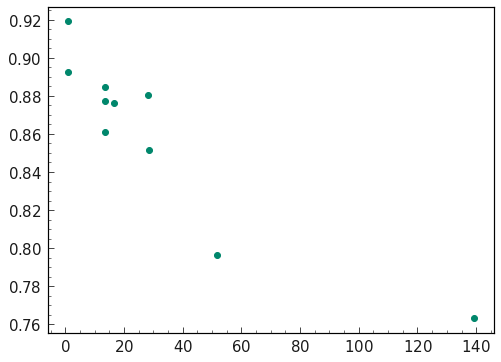

In [18]:
plt.plot(test[:,0], test[:,1], 'o')